# Ship Detection using Satellite Images
## Facundo Espina

## 1. Introduction

**Company Background**

The company is OceanSight, and it focuses on studying and exploring the ocean to gain valuable insights. The interesting thing is that OceanSight does this from space. Using satellite imagery, it observes the ocean from the sky, unlocking a unique perspective.

We work in the Port division. Understanding the operation, logistics, volume, and trends in ports, as well as critical areas like the Suez Canal and Panama Canal, is essential to keeping the global supply chain running smoothly. Even minor changes in these key regions can trigger a snowball effect, potentially affecting supply chains and logistics on a global scale.

Additionally, monitoring port operations can help identify potential investment opportunities. For instance, a high volume of raw materials flowing into a specific port could indicate growth in a particular industry. This might be a signal of a promising area for investment. By analyzing these patterns, stakeholders can identify inefficiencies or chokepoints and gain valuable insights into emerging market trends, strategically positioning themselves for future opportunities.

**Problem Statement**

To align with OceanSight's objectives, we aim to develop a Machine Learning model capable of identifying and tracking ships from satellite images. This model will allow OceanSight to monitor the volume of ships at specific ports or key maritime zones, analyze trends, and optimize operations. The first step is being able to identify a ship from a satellite image, which is what we are trying to achieve. 

The value and impact of achieving this first step would be huge. For example, the model could help measure port operation times, identify queues, and suggest alternative routes. For instance, taking a slightly longer route to a less congested port might result in faster unloading and reduced delays in the overall supply chain.

**Data Source**

We have access to a labeled dataset of satellite images containing examples of ships. 
This dataset will be used to train the model capable of identifying and counting ships.  
[Ships in Satellite Imagery Dataset](https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data)


## 2. Data Exploration

**Library Import**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import hashlib

import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings 
warnings.filterwarnings('ignore')

**Read the dataset**

In [2]:
with open('shipsnet.json') as f:
    dataset = json.load(f)



**Check dataset keys**

To make sure there is no missing data

In [3]:
print(dataset.keys())

# check the length of each key
print(f"Number of images: {len(dataset['data'])}")
print(f"Number of labels: {len(dataset['labels'])}")
print(f"Number of scene IDs: {len(dataset['scene_ids'])}")
print(f"Number of locations: {len(dataset['locations'])}")


dict_keys(['data', 'labels', 'locations', 'scene_ids'])
Number of images: 4000
Number of labels: 4000
Number of scene IDs: 4000
Number of locations: 4000




**Display the first image**

To ensure the dataset was read correctly

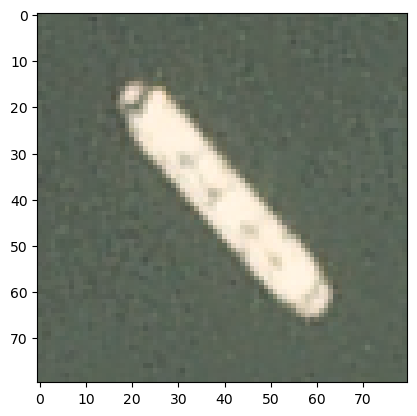

In [4]:
# convert to original dimensions
first_image = np.array(dataset['data'][0]).reshape((3, 80, 80)).transpose(1, 2, 0) / 255.0

plt.imshow(first_image)
plt.axis('on')
plt.show()





**Display a sample of each class**

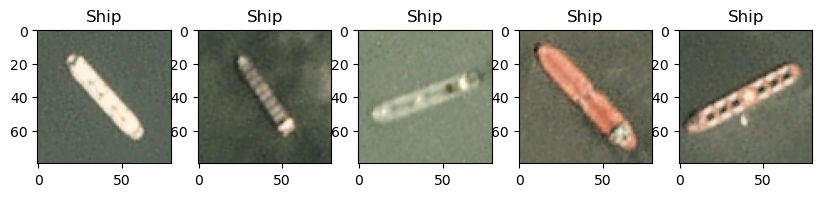

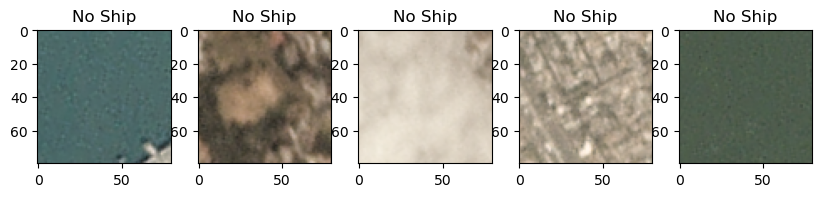

In [5]:
# extract ships and no-ships index by looping images
ships_index = []
no_ships_index = []

for i, label in enumerate(dataset['labels']):
    if label == 1:
        ships_index.append(i)
    else:
        no_ships_index.append(i)


# display 5 ship images
plt.figure(figsize=(10, 5))
for i in range(5):
    img = np.array(dataset['data'][ships_index[i]]).reshape((3, 80, 80)).transpose(1, 2, 0) / 255.0
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title('Ship')
    plt.axis('on')

plt.show()

# display 5 no-ship images
plt.figure(figsize=(10, 5))
for i in range(5):
    img = np.array(dataset['data'][no_ships_index[i]]).reshape((3, 80, 80)).transpose(1, 2, 0) / 255.0
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title('No Ship')
    plt.axis('on')

plt.show()




**Calculate the ship size**

Claculate each ship size by analysing the brightness of the pixels and counting said pixels in each image.

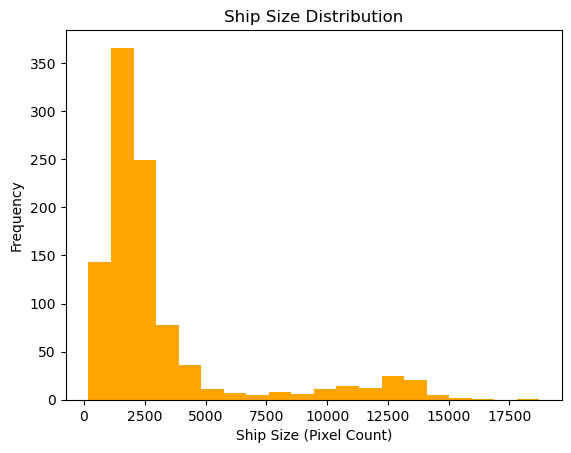

In [6]:
def calculate_ship_size(image):
    return np.sum(image > 0.5)

ship_sizes = []

for i in ships_index:
    image = np.array(dataset['data'][i]).reshape(3, 80, 80).transpose(1, 2, 0) / 255.0
    size = calculate_ship_size(image)
    ship_sizes.append(size)

plt.hist(ship_sizes, bins=20, color='orange')
plt.title('Ship Size Distribution')
plt.xlabel('Ship Size (Pixel Count)')
plt.ylabel('Frequency')
plt.show()




**Check if there are any duplicated images**


the method used to identify duplicates is: loop through the dataset, get the index and image, rearrange the image, convert it to bytes, and generate a unique hash for it. These hashes are stored in a dictionary, where images having the same hash are grouped together.

In [7]:
hashes = {}

# loop through images and calculate their hashes
for i, img_data in enumerate(dataset['data']):
    img = np.array(img_data).reshape(3, 80, 80).transpose(1, 2, 0)
    img_hash = hashlib.md5(img.tobytes()).hexdigest()
    
    hashes.setdefault(img_hash, []).append(i)

duplicates = {}
# loop throuhh hashes
for h, idx in hashes.items():
    if len(idx) > 1:
        duplicates[h] = idx

print(f"Number of duplicate images: {len(duplicates)}")


Number of duplicate images: 0




**Visualize Class Distribution**

No-ship: 3000
Ship:    1000


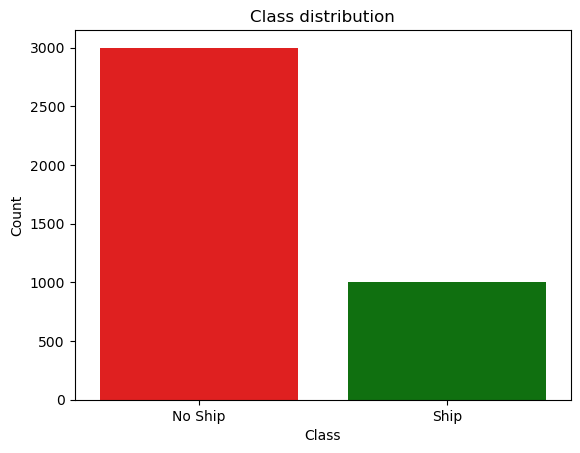

In [8]:
# Convert labels to a df
df = pd.DataFrame({'label': dataset['labels']})
print(f"No-ship: {(df['label'] == 0).sum()}")
print(f"Ship:    {(df['label'] == 1).sum()}")


# Plot distribution
sns.countplot(x='label', data=df, palette=['red', 'green'])
plt.xticks(ticks=[0, 1], labels=['No Ship', 'Ship'])
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


**Data Exploration Summary:**

- Dataset consists of 4000 images with corresponding labels, locations, and scene ids.
- All data components (data, labels, locations, scene_ids) align correctly.
- 3000 images are labeled "No Ship".
- 1000 images are labeled "Ship".
- There is a class imbalance (3:1), may require oversampling, augmentation, or class-weight adjustments during model training.
- "Ship" images show diversity in color, size, and orientation.
- "No Ship" images include backgrounds like water, ports, trucks, clouds, and land.
- Most ships have a small pixel footprint (< 2500 pixels), with a few larger ships.
- The model may need to handle small object detection effectively.
- No duplicate images were found.
- Small ships in noisy backgrounds might be difficult to detect.
- Class imbalance might bias the model towards predicting "No Ship".

## 3. Evaluation Metric Definition

**Define a evaluation function**

This function is used for the model validation and testing datasets

In [9]:
def evaluate_model(model, X, y, class_names=None):
    # Convert one-hot labels to categorical
    if len(y.shape) == 2:
        y_cat = np.argmax(y, axis=1)
    else:
        y_cat = y

    # predictions
    y_pred = model.predict(X)
    y_pred_cat = np.argmax(y_pred, axis=1)

    # accuracy
    accuracy = accuracy_score(y_cat, y_pred_cat)
    print(f"Accuracy: {accuracy:.4f}")

    # confusion matrix
    cm = confusion_matrix(y_cat, y_pred_cat)
    print("Confusion Matrix:")
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # classification report
    print("Classification Report:")
    print(classification_report(y_cat, y_pred_cat, target_names=class_names))


## 4. Data Preprocessing & Feature Engineering

**Data Normalization**

In [10]:
# normalize data to [0, 1]
normalized_data = np.array(dataset['data']) / 255.0
labels = np.array(dataset['labels'])

# reshape data to (N, H, W, C)
normalized_data = normalized_data.reshape(-1, 80, 80, 3)

**Split the Data**

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(normalized_data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}") 
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (2800, 80, 80, 3)
Validation set: (600, 80, 80, 3)
Test set: (600, 80, 80, 3)




**Handle Data Imbalance**

Dpoing this because oversampling ship class or undersampling no-ship class worked worse than class weights.

In [12]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"new class weights: {class_weights}")

new class weights: {0: 0.6619385342789598, 1: 2.0437956204379564}




**Data Augmentation**

Manipulating existing data and create "new versions" of the existing data. to have a higher sample

In [13]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    zoom_range=0.1,
    rescale=1.0
)

## 5. Model Training

We encode the labels, define the model and the layers, compile everything, set the early stop with relatively high patience and train the model.

model_cnn is our baseline model

In [14]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# One-hot encode the labels
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)

# Define the CNN model
model_cnn = Sequential()

# Convolutional layers
model_cnn.add(Conv2D(filters=64, kernel_size=(4, 4), padding='Same', activation='relu', input_shape=(80, 80, 3)))
model_cnn.add(MaxPooling2D(pool_size=(5, 5)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(filters=16, kernel_size=(2, 2), padding='Same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model_cnn.add(Dropout(0.25))

# Fully connected layers
model_cnn.add(Flatten())
model_cnn.add(Dense(200, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(100, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(100, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(50, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2, activation="softmax"))

# Compile the model
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Define early stop callback
earlystop = callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=10, restore_best_weights=True
)

# Train the model
history = model_cnn.fit(
    X_train, y_train_cat,
    epochs=100,
    validation_data=(X_val, y_val_cat),
    class_weight=class_weights,
    callbacks=[earlystop]
)


Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4804 - loss: 0.7219 - val_accuracy: 0.2467 - val_loss: 0.6946
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2977 - loss: 0.6960 - val_accuracy: 0.7533 - val_loss: 0.6926
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5330 - loss: 0.6888 - val_accuracy: 0.2467 - val_loss: 0.6948
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.3313 - loss: 0.6875 - val_accuracy: 0.7533 - val_loss: 0.6900
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6228 - loss: 0.6849 - val_accuracy: 0.2467 - val_loss: 0.7000
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4621 - loss: 0.6705 - val_accuracy: 0.7850 - val_loss: 0.6428
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6888 - loss: 0.6339 - val_accuracy: 0.8267 - val_loss: 0.5389
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8345 - loss: 0.5191 - val_accuracy: 0.

**Model Evaluation**

with validation dataset

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.9750
Confusion Matrix:


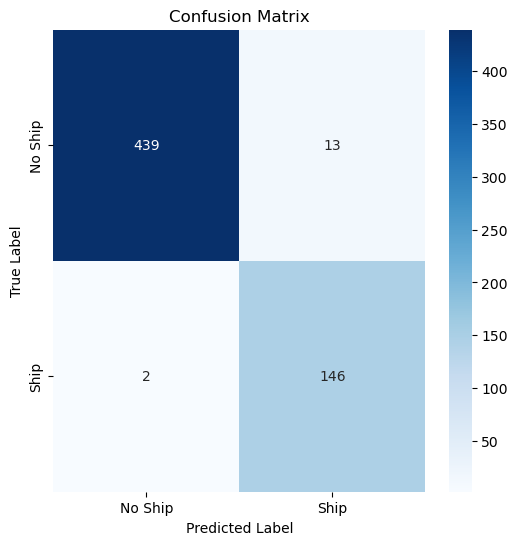

Classification Report:
              precision    recall  f1-score   support

     No Ship       1.00      0.97      0.98       452
        Ship       0.92      0.99      0.95       148

    accuracy                           0.97       600
   macro avg       0.96      0.98      0.97       600
weighted avg       0.98      0.97      0.98       600



In [15]:
class_names = ['No Ship', 'Ship']

evaluate_model(model_cnn, X_val, y_val_cat, class_names=class_names)

## 6. Experiment Section

In this section I create a function to execute cnn with different parameters, then define the parameter variations and run the experiments depending on the different parameters.

In [16]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU

# function to create a CNN model with configurable parameters
def create_model(filters, kernel_size, dropout_rate, optimizer, learning_rate, activation='relu'):
    model = Sequential()
    
    # first convolutional layer
    if activation == 'LeakyReLU':
        activation_layer = LeakyReLU(alpha=0.1)
    else:
        activation_layer = activation

    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation_layer, input_shape=(80, 80, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate))

    # second convolutional layer
    model.add(Conv2D(filters=filters // 2, kernel_size=(3, 3), activation=activation_layer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate))

    # fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation=activation_layer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))

    # optimizer
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# experiment variations
experiments = [
    {"variant": "No augmentation", "augmentation": None, "optimizer": "Adam", "lr": 0.001, "dropout": 0.3, "filters": 64},
    {"variant": "Full augmentation", "augmentation": True, "optimizer": "Adam", "lr": 0.001, "dropout": 0.3, "filters": 64},
    {"variant": "Increased filters (128)", "augmentation": None, "optimizer": "Adam", "lr": 0.001, "dropout": 0.3, "filters": 128},
    {"variant": "Larger kernel size (5x5)", "augmentation": None, "optimizer": "Adam", "lr": 0.001, "dropout": 0.3, "filters": 64, "kernel_size": (5, 5)},
    {"variant": "Lower dropout (0.2)", "augmentation": None, "optimizer": "Adam", "lr": 0.001, "dropout": 0.2, "filters": 64},
    {"variant": "Higher dropout (0.5)", "augmentation": None, "optimizer": "Adam", "lr": 0.001, "dropout": 0.5, "filters": 64},
    {"variant": "Optimizer = SGD", "augmentation": None, "optimizer": "SGD", "lr": 0.001, "dropout": 0.3, "filters": 64},
    {"variant": "Learning rate = 0.0001", "augmentation": None, "optimizer": "Adam", "lr": 0.0001, "dropout": 0.3, "filters": 64},
    {"variant": "Batch size = 16", "augmentation": None, "optimizer": "Adam", "lr": 0.001, "dropout": 0.3, "filters": 64, "batch_size": 16},
    {"variant": "Batch size = 64", "augmentation": None, "optimizer": "Adam", "lr": 0.001, "dropout": 0.3, "filters": 64, "batch_size": 64},
    {"variant": "LeakyReLU activation", "augmentation": None, "optimizer": "Adam", "lr": 0.001, "dropout": 0.3, "filters": 64, "activation": "LeakyReLU"},
    {"variant": "Class weights balancing", "augmentation": None, "optimizer": "Adam", "lr": 0.001, "dropout": 0.3, "filters": 64, "class_weights": True},
]


results = []

# run experiments
for exp in experiments:
    print(f"Running: {exp['variant']}")
    
    # data augmentation
    if exp['augmentation']:
        train_gen = datagen.flow(X_train, y_train_cat, batch_size=32)
    else:
        train_gen = None
    
    # class weights
    if 'class_weights' in exp and exp['class_weights']:
        class_weights = class_weights
    else:
        class_weights = None
    
    # batch size
    batch_size = exp.get("batch_size", 32)
    
    # kernel size
    kernel_size = exp.get("kernel_size", (3, 3))
    
    # activation function
    activation = exp.get("activation", "relu")
    
    # create the model
    model = create_model(filters=exp['filters'], kernel_size=kernel_size, dropout_rate=exp['dropout'], 
                         optimizer=exp['optimizer'], learning_rate=exp['lr'], activation=activation)
    
    # early stop
    earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # training: for augmentation and no augmentation
    if exp['augmentation']:
        history = model.fit(
            train_gen,
            validation_data=(X_val, y_val_cat),
            epochs=20,
            callbacks=[earlystop],
            verbose=0,
            class_weight=class_weights
        )
    else:
        history = model.fit(
            X_train, y_train_cat,
            validation_data=(X_val, y_val_cat),
            epochs=20,
            callbacks=[earlystop],
            verbose=0,
            batch_size=batch_size,
            class_weight=class_weights
        )
    
    # evaluation
    val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
    results.append({"Variant": exp["variant"], "Validation Accuracy": f"{val_acc:.2%}"})

# Convert results to a df
results_df = pd.DataFrame(results)

Running: No augmentation
Running: Full augmentation
Running: Increased filters (128)
Running: Larger kernel size (5x5)
Running: Lower dropout (0.2)
Running: Higher dropout (0.5)
Running: Optimizer = SGD
Running: Learning rate = 0.0001
Running: Batch size = 16
Running: Batch size = 64
Running: LeakyReLU activation
Running: Class weights balancing


#### Experiment Results

| Variant                     | Validation Accuracy | Optimizer | Learning Rate (lr) | Dropout | Filters | Augmentation | Batch Size | Activation | Class Weights |
|-----------------------------|----------------------|-----------|--------------------|---------|---------|-------------|------------|------------|---------------|
| No augmentation             | 99.00%              | Adam      | 0.001              | 0.3     | 64      | None        | 32         | ReLU       | None          |
| Full augmentation           | 75.33%              | Adam      | 0.001              | 0.3     | 64      | True        | 32         | ReLU       | None          |
| Increased filters (128)     | 98.83%              | Adam      | 0.001              | 0.3     | 128     | None        | 32         | ReLU       | None          |
| Larger kernel size (5x5)    | 98.83%              | Adam      | 0.001              | 0.3     | 64      | None        | 32         | ReLU       | None          |
| Lower dropout (0.2)         | 98.67%              | Adam      | 0.001              | 0.2     | 64      | None        | 32         | ReLU       | None          |
| Higher dropout (0.5)        | 98.67%              | Adam      | 0.001              | 0.5     | 64      | None        | 32         | ReLU       | None          |
| Optimizer = SGD             | 88.50%              | SGD       | 0.001              | 0.3     | 64      | None        | 32         | ReLU       | None          |
| Learning rate = 0.0001      | 93.17%              | Adam      | 0.0001             | 0.3     | 64      | None        | 32         | ReLU       | None          |
| Batch size = 16             | 99.00%              | Adam      | 0.001              | 0.3     | 64      | None        | 16         | ReLU       | None          |
| Batch size = 64             | 98.67%              | Adam      | 0.001              | 0.3     | 64      | None        | 64         | ReLU       | None          |
| LeakyReLU activation        | 98.67%              | Adam      | 0.001              | 0.3     | 64      | None        | 32         | LeakyReLU  | None          |
| Class weights balancing     | 98.83%              | Adam      | 0.001              | 0.3     | 64      | None        | 32         | ReLU       | True          |


## 7. Model Assessment

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.9717
Confusion Matrix:


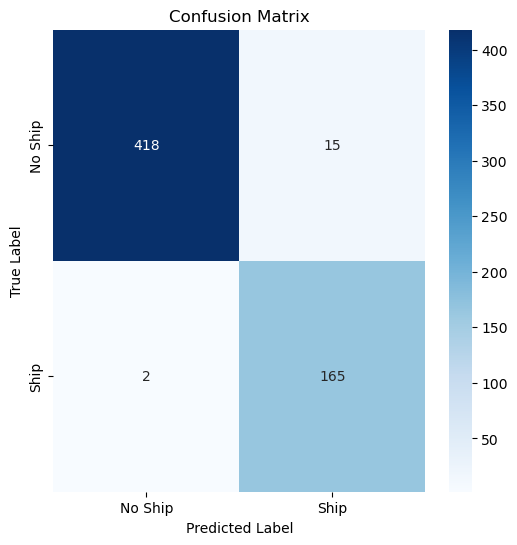

Classification Report:
              precision    recall  f1-score   support

     No Ship       1.00      0.97      0.98       433
        Ship       0.92      0.99      0.95       167

    accuracy                           0.97       600
   macro avg       0.96      0.98      0.97       600
weighted avg       0.97      0.97      0.97       600



In [17]:
class_names = ['No Ship', 'Ship']

evaluate_model(model_cnn, X_test, y_test, class_names=class_names)

## 8. Final Discussion

The pipeline is capable of identifying ships in satellite imagery to support OceanSight's goal of monitoring maritime operations, optimizing port logistics, and improving supply chain efficiency. 

##### **Strengths**
   - The model achieved **97.17% accuracy** on the test set, it is a strong performance in distinguishing between "Ship" and "No Ship" images.
   - High precision and recall for the "Ship" class highlight the model's capability to minimize false positives and negatives.

   - By using class weighting, the model effectively managed the 3:1 class imbalance, avoiding bias toward "No Ship" class.
   - This improves generalization.

   - Systematic experimentation with parameters this ensured the model was well-tuned for the problem.
   - Data augmentation helped in some cases but full augmentation lowered performance


##### **Limitations**
   - Smaller ships in cluttered or noisy backgrounds remain more challenging for the model, as seen  in occasional misclassifications.
   - This could affect scenarios where accurate detection of smaller ships is critical.

   - The dataset is relatively small (4000 images), which may limit the model's ability to generalize to unseen conditions.

   - The model performs well, but it is a black-box system. The decision-making process is not easily interpretable.

   - The model only focuses on detecting ships, but it would be useful to detect ship types, sizes, details.


##### **Business Problem**
   - The model can support OceanSight's goals by automating the detection of ships in key regions, enabling real-time monitoring of port activity and congestion levels.

   - Insights from ship volumes and port activity could show emerging trade routes, potential infrastructure needs, or industries growing, allowing to identify investment opportunities.

   - Early identification of congestion in critical maritime zones could help plan routes proactively, reducing delays and ensuring smoother supply chain operations.


##### **Next Steps**

   - Incorporate additional satellite imagery with more diverse conditions and diverse types of ships.

   - Use interpretability methods like SHAP to visualize which characteristics of an image contribute most to the model's predictions.

   - Extend the model to not only detect ships but also classify them based on size or type.

   - Deploy the model into real-time satellite monitoring systems.
